# **GUIDE TO UTILIZING THE NUCLS DATASET**

This document offers a concise overview of methods for loading and examining the (NuCLS dataset)[https://huggingface.co/datasets/minhanhto09/NuCLS_dataset]. Additionally, we present a technique for leveraging YOLO for the purpose of nuclei detection.

Outlined below is the structure of this guide:

  1. Loading and Exploring the Dataset
  2. Implementing a **YOLOv8** Model for the **Nuclei Object Detection** Task
  
    i) Modifying image dimensions and aligning annotation coordinates

    ii) Training the models to update weights

    iii) Use the model to predict labels, bounding boxes and confidence scores

## **Download packages**

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import pandas as pd
import numpy as np

from PIL import Image, ImageOps
import datasets
from datasets import load_dataset, concatenate_datasets
import os
import io
from typing import Tuple, Dict, List

import random
import zipfile
import requests
from io import BytesIO

import seaborn as sns
from collections import defaultdict, Counter
import matplotlib.cm as cm

import matplotlib.pyplot as plt
import matplotlib.patches as patches


import yaml

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Set the working directory in Google Drive
os.chdir('/content/drive/MyDrive/YOLOV8')

Mounted at /content/drive


## **1. LOAD THE DATASET**

There are two versions of the dataset: the full version and the small one, depending on your needs. For quick viewing and debugging, load the small version by adjusting the name argument to `name = debug`. Load the full version by setting `name = default`.

In [5]:
# @title **1. Load the dataset**

# Load the dataset
dataset = load_dataset("minhanhto09/NuCLS_dataset", name="default")
# Combine folds into train and test
train_splits = [dataset[f'train_fold_{i}'] for i in range(1, 6)]
combined_train = concatenate_datasets(train_splits)

test_splits = [dataset[f'test_fold_{i}'] for i in range(1, 6)]
combined_test = concatenate_datasets(test_splits)

# Create a new dataset dictionary
dataset = {'train': combined_train, 'test': combined_test}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.08k [00:00<?, ?B/s]

NuCLS_dataset.py:   0%|          | 0.00/12.1k [00:00<?, ?B/s]

The repository for minhanhto09/NuCLS_dataset contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/minhanhto09/NuCLS_dataset.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train_fold_5 split: 0 examples [00:00, ? examples/s]

Generating test_fold_5 split: 0 examples [00:00, ? examples/s]

Generating train_fold_4 split: 0 examples [00:00, ? examples/s]

Generating test_fold_4 split: 0 examples [00:00, ? examples/s]

Generating train_fold_3 split: 0 examples [00:00, ? examples/s]

Generating test_fold_3 split: 0 examples [00:00, ? examples/s]

Generating train_fold_999 split: 0 examples [00:00, ? examples/s]

Generating test_fold_999 split: 0 examples [00:00, ? examples/s]

Generating train_fold_1 split: 0 examples [00:00, ? examples/s]

Generating test_fold_1 split: 0 examples [00:00, ? examples/s]

Generating train_fold_2 split: 0 examples [00:00, ? examples/s]

Generating test_fold_2 split: 0 examples [00:00, ? examples/s]

In [5]:
# Load a fold from the dataset

# dataset = load_dataset("minhanhto09/NuCLS_dataset", split={'train': 'train_fold_1', 'test': 'test_fold_1'})

## **2. RUN A YOLOV8 MODEL FOR NUCLEI INSTANCE SEGMENTATION TASK**

### 1. **Resources**

This implementation follows closely with the structure of how to train a custom object detection model with YOLOv8: https://huggingface.co/Ultralytics/YOLOv8

### 2. **Discussions and implementation**

One significant obstacle in applying the **YOLOv8 model** to this dataset stems from the variability in image dimensions. Each image is paired with a detailed set of annotation coordinates that encapsulate comprehensive data about every nucleus and its respective label—think of it as a dedicated CSV file accompanying each image group. Consequently, we must devise a method to uniformly resize the images while correspondingly adjusting the annotation coordinates. Unlike models such as YOLOv5, which typically assign a single label to an entire image, our challenge is compounded by having multiple labels for various elements within a single image.

The secondary challenge involves transforming the image_name and annotation coordinates into a single text file, while the array of labels must be converted into a separate text file.

Below are the steps that I implemented to circumvent the above two problems.

## **i. Setup**

Pip install `ultralytics` and [dependencies](https://github.com/ultralytics/ultralytics/blob/main/pyproject.toml) and check software and hardware.

In [2]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

from ultralytics import YOLO

Ultralytics 8.3.62 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 31.1/235.7 GB disk)


## **ii. Resize Images and Adjust Annotation Coordinates**

In [7]:
# @title Functions to resize images and adjust annotation coordinates

def resize_image(image, target_size=(640, 640)):
    """
    Resize an image while preserving its aspect ratio. Adds padding to maintain the aspect ratio.
    Returns the resized image and the scale factors for width and height.
    """
    # Calculate the scale needed for each side
    scale = min(target_size[0] / image.width, target_size[1] / image.height)

    # Calculate the new size and resize the image
    new_size = (int(image.width * scale), int(image.height * scale))
    resized_image = image.resize(new_size, Image.LANCZOS)

    # Calculate padding to be applied
    padding = (
        (target_size[0] - new_size[0]) // 2,  # Left padding
        (target_size[1] - new_size[1]) // 2,  # Top padding
    )
    # Create a new image with the required size and paste the resized image into it
    padded_image = Image.new("RGB", target_size)
    padded_image.paste(resized_image, padding)

    return padded_image, scale, padding

def adjust_annotation_coordinates(coords, scale, padding):
    """
    Adjust the annotation coordinates based on the image scaling and padding.
    """
    adjusted_coords = {}
    for key in ['xmin', 'ymin', 'xmax', 'ymax']:
        scaled_coords = np.array(coords[key]) * scale  # Scale the coordinates
        if key in ['xmin', 'xmax']:
            adjusted_coords[key] = (scaled_coords + padding[0]).tolist()  # Apply x padding
        elif key in ['ymin', 'ymax']:
            adjusted_coords[key] = (scaled_coords + padding[1]).tolist()  # Apply y padding

    return adjusted_coords

In [25]:
# @title A function to plot the bounding boxes from the annotation_coordinates

def plot_annotated_image_with_labels(entry):
    rgb_image = entry['rgb_image']
    annotation_coords = entry['annotation_coordinates']

    # Create a figure and a single subplot
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(rgb_image)

    # Get bounding box coordinates and classifications
    xmin = annotation_coords['xmin']
    xmax = annotation_coords['xmax']
    ymin = annotation_coords['ymin']
    ymax = annotation_coords['ymax']
    labels_super = annotation_coords['super_classification']
    labels_raw = annotation_coords['raw_classification']
    labels_main = annotation_coords['main_classification']


    for x3, y3, x4, y4, label2 in zip(xmin, ymin, xmax, ymax, labels_super):
        # Draw the rectangle
        rect = patches.Rectangle((x3, y3), x4 - x3, y4 - y3, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # Place a text label
        ax.text(x3, y3, label2, fontsize=8, bbox=dict(facecolor='yellow', alpha=0.5), verticalalignment='top')

    # Set plot titles and labels
    plt.title('Annotated RGB Image with SuperClass_Labels')
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(rgb_image)
    for x1, y1, x2, y2, label in zip(xmin, ymin, xmax, ymax, labels_main):
        # Draw the rectangle
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # Place a text label
        ax.text(x1, y1, label, fontsize=8, bbox=dict(facecolor='green', alpha=0.5), verticalalignment='top')
    plt.title('Annotated RGB Image with MainClass_Labels')
    plt.show()

## **iii. Preprocess the data**

Note that we will proceed with the super classification (5 classes). The code can be slightly modified if more fine-grained classifications are needed, such as main classification (7 classes) or raw classification (13 classes).

In [20]:
# Print unique classes in the dataset
def print_unique_classes(dataset, split_name):
    unique_classes = set()
    for sample in dataset[split_name]:
        classes = sample['annotation_coordinates']['super_classification']
        unique_classes.update(classes)
    print(f"Unique classes in {split_name} set:", unique_classes)

print_unique_classes(dataset, 'train')
print_unique_classes(dataset, 'test')

Unique classes in train set: {'tumor_any', 'nonTIL_stromal', 'AMBIGUOUS', 'sTIL', 'other_nucleus'}
Unique classes in test set: {'tumor_any', 'nonTIL_stromal', 'AMBIGUOUS', 'sTIL', 'other_nucleus'}


In [ ]:
# @title Train the Data based on the main classification (For 7 classes) - Not used

def create_dataset_files(dataset, split_name, base_path, target_size=(640, 640)):
    image_dir = os.path.join(base_path, 'images', split_name)
    label_dir = os.path.join(base_path, 'labels', split_name)

    # Ensure the directories exist
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    for sample in dataset[split_name]:
        image = sample['rgb_image']  # This is a PIL image
        image_path = os.path.join(image_dir, f"{sample['file_name']}.png")
        label_path = os.path.join(label_dir, f"{sample['file_name']}.txt")

        # Resize image and get new scale and padding
        resized_image, scale, padding = resize_image(image, target_size)

        # Save resized image
        resized_image.save(image_path)

        # Adjust annotation coordinates
        adjusted_coords = adjust_annotation_coordinates(sample['annotation_coordinates'], scale, padding)

        # Write annotations to label file
        #class_map = {'AMBIGUOUS':0, 'lymphocyte':1, 'macrophage':2, 'nonTILnonMQ_stromal':3, 'plasma_cell':4, 'tumor_mitotic':5, 'tumor_nonMitotic':6}

        with open(label_path, 'w') as f:
                    for i in range(len(adjusted_coords['xmin'])):
                        class_id = {'AMBIGUOUS':0, 'lymphocyte':1, 'macrophage':2, 'nonTILnonMQ_stromal':3,
                'plasma_cell':4, 'tumor_mitotic':5, 'tumor_nonMitotic':6}.get(sample['annotation_coordinates']['main_classification'][i], -1)
                        x_center = ((adjusted_coords['xmin'][i] + adjusted_coords['xmax'][i]) / 2) / target_size[0]
                        y_center = ((adjusted_coords['ymin'][i] + adjusted_coords['ymax'][i]) / 2) / target_size[1]
                        width = (adjusted_coords['xmax'][i] - adjusted_coords['xmin'][i]) / target_size[0]
                        height = (adjusted_coords['ymax'][i] - adjusted_coords['ymin'][i]) / target_size[1]
                        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")


def create_yaml_file(base_path, dataset_names):
    data_dict = {
        'path': base_path,
        'train': os.path.join('images', 'train'),
        'val': os.path.join('images', 'test'),
        'nc': 7,  # Number of classes
        'names': ['AMBIGUOUS', 'lymphocyte', 'macrophage', 'nonTILnonMQ_stromal', 'plasma_cell', 'tumor_mitotic', 'tumor_nonMitotic']
    }

    with open(os.path.join(base_path, 'data.yaml'), 'w') as file:
        yaml.dump(data_dict, file, sort_keys=False)

# Define paths and dataset names
base_path = '/content/drive/MyDrive/YOLOV8'

# Run the functions
create_dataset_files(dataset, 'train', base_path)
create_dataset_files(dataset, 'test', base_path)
create_yaml_file(base_path, {'train': 'train.txt', 'test': 'test.txt'})

In [ ]:
# @title Raw Classfication Case (For 13 classes) - Not used
labels_dict = {
  'fov': 0, # dummy variable to feed into the model
  'tumor': 1,
  'fibroblast': 2,
  'lymphocyte': 3,
  'plasma_cell': 4,
  'macrophage': 5,
  'mitotic_figure': 6,
  'vascular_endothelium': 7,
  'myoepithelium': 8,
  'apoptotic_body': 9,
  'neutrophil': 10,
  'ductal_epithelium': 11,
  'eosinophil': 12,
  'unlabeled': 13
}

# create a function that maps the label to its value
def map_label_to_value(label):
    return labels_dict[label]

In [8]:
# @title Train the Data based on the super classification (For 5 classes) - Used

def create_dataset_files(dataset, split_name, base_path, target_size=(640, 640)):
    image_dir = os.path.join(base_path, 'images', split_name)
    label_dir = os.path.join(base_path, 'labels', split_name)

    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    skipped_count = 0
    processed_count = 0

    for sample in dataset[split_name]:
        image = sample['rgb_image']
        image_path = os.path.join(image_dir, f"{sample['file_name']}.png")
        label_path = os.path.join(label_dir, f"{sample['file_name']}.txt")

        # Resize image and get new scale and padding
        resized_image, scale, padding = resize_image(image, target_size)
        resized_image.save(image_path)

        # Adjust annotation coordinates
        adjusted_coords = adjust_annotation_coordinates(sample['annotation_coordinates'], scale, padding)

        # Write annotations to label file
        valid_labels = False
        with open(label_path, 'w') as f:
            for i in range(len(adjusted_coords['xmin'])):
                # Get super_classification and handle missing values
                class_name = sample['annotation_coordinates']['super_classification'][i]
                class_id = {
                    'AMBIGUOUS': 0,
                    'nonTIL_stromal': 1,
                    'sTIL': 2,
                    'tumor_any': 3,
                    'other_nucleus': 4
                }.get(class_name)

                # Skip if class_id is None (unknown class)
                if class_id is not None:
                    valid_labels = True
                    x_center = ((adjusted_coords['xmin'][i] + adjusted_coords['xmax'][i]) / 2) / target_size[0]
                    y_center = ((adjusted_coords['ymin'][i] + adjusted_coords['ymax'][i]) / 2) / target_size[1]
                    width = (adjusted_coords['xmax'][i] - adjusted_coords['xmin'][i]) / target_size[0]
                    height = (adjusted_coords['ymax'][i] - adjusted_coords['ymin'][i]) / target_size[1]

                    # Write only if coordinates are valid
                    if 0 <= x_center <= 1 and 0 <= y_center <= 1 and width > 0 and height > 0:
                        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

        if not valid_labels:
            os.remove(label_path)
            os.remove(image_path)
            skipped_count += 1
        else:
            processed_count += 1

    print(f"{split_name} set: Processed {processed_count} images, Skipped {skipped_count} images")

def create_yaml_file(base_path, dataset_names):
    data_dict = {
        'path': base_path,
        'train': os.path.join('images', 'train'),
        'val': os.path.join('images', 'test'),
        'nc': 5,  # Number of classes
        'names': ['nonTIL_stromal', 'tumor_any', 'AMBIGUOUS', 'other_nucleus', 'sTIL']
    }

    with open(os.path.join(base_path, 'data.yaml'), 'w') as file:
        yaml.dump(data_dict, file, sort_keys=False)

# Define paths and dataset names
base_path = '/content/drive/MyDrive/YOLOV8'

# Run the functions
create_dataset_files(dataset, 'train', base_path)
create_dataset_files(dataset, 'test', base_path)
create_yaml_file(base_path, {'train': 'train.txt', 'test': 'test.txt'})

train set: Processed 6976 images, Skipped 0 images
test set: Processed 1744 images, Skipped 0 images


## **Train with the YOLO v8m models**

In [9]:
# Load a model
model = YOLO('yolov8m.pt')

In [10]:
# Training with visualization
results = model.train(
    data='/content/drive/MyDrive/YOLOV8/data.yaml',
    epochs=15,
    imgsz=640,
    batch=16,
    plots=True,  # Generate plots
    save=True,   # Save model
    device=0,    # Use GPU if available
    verbose=True
)


Ultralytics 8.3.62 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/YOLOV8/data.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

100%|██████████| 755k/755k [00:00<00:00, 20.4MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

train: Scanning /content/drive/MyDrive/YOLOV8/labels/train.cache... 1744 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1744/1744 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/YOLOV8/images/train/TCGA-BH-A1EW-DX1_id-5ea40ad0ddda5f839899478d_left-68221_top-44015_bottom-44251_right-68532.png: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/YOLOV8/labels/test.cache... 1744 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1744/1744 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/YOLOV8/images/test/TCGA-BH-A1EW-DX1_id-5ea40ad0ddda5f839899478d_left-68221_top-44015_bottom-44251_right-68532.png: 1 duplicate labels removed


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      8.68G      1.874      1.871      1.498        920        640: 100%|██████████| 109/109 [01:20<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


                   all       1744      59373      0.489      0.421       0.34      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      7.95G       1.79       1.54       1.44        619        640: 100%|██████████| 109/109 [01:21<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:55<00:00,  1.00s/it]


                   all       1744      59373      0.539      0.415      0.353      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15         8G      1.777      1.496      1.438        799        640: 100%|██████████| 109/109 [01:19<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


                   all       1744      59373      0.554      0.416      0.357      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      7.98G      1.776      1.458      1.449        768        640: 100%|██████████| 109/109 [01:17<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:56<00:00,  1.02s/it]


                   all       1744      59373       0.64      0.375      0.381      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      8.39G       1.74      1.426      1.425        709        640: 100%|██████████| 109/109 [01:17<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:53<00:00,  1.04it/s]


                   all       1744      59373      0.571      0.447      0.409      0.207
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      7.22G       1.76      1.447      1.492        462        640: 100%|██████████| 109/109 [01:18<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:53<00:00,  1.04it/s]


                   all       1744      59373      0.578      0.448      0.401      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      7.84G      1.737      1.384      1.487        474        640: 100%|██████████| 109/109 [01:16<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:52<00:00,  1.06it/s]


                   all       1744      59373      0.418       0.46      0.418      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      7.84G      1.733      1.374      1.478        626        640: 100%|██████████| 109/109 [01:16<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


                   all       1744      59373      0.587      0.475      0.447      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15       7.5G      1.718      1.331      1.468        599        640: 100%|██████████| 109/109 [01:16<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:51<00:00,  1.07it/s]


                   all       1744      59373      0.477      0.481      0.457      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      7.89G      1.712      1.313      1.467        460        640: 100%|██████████| 109/109 [01:17<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:51<00:00,  1.06it/s]


                   all       1744      59373      0.603      0.476      0.455       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      7.24G      1.692      1.284       1.45        517        640: 100%|██████████| 109/109 [01:16<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:49<00:00,  1.11it/s]


                   all       1744      59373      0.521      0.529      0.487       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15         8G       1.69      1.257      1.458        551        640: 100%|██████████| 109/109 [01:14<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:49<00:00,  1.12it/s]


                   all       1744      59373      0.622      0.499      0.506      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      7.73G       1.67      1.228       1.45        644        640: 100%|██████████| 109/109 [01:13<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:50<00:00,  1.09it/s]


                   all       1744      59373      0.536      0.564      0.531      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      7.32G      1.661      1.198      1.447        475        640: 100%|██████████| 109/109 [01:14<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


                   all       1744      59373      0.548      0.572      0.544      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      7.95G      1.645       1.18      1.438        590        640: 100%|██████████| 109/109 [01:16<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:51<00:00,  1.07it/s]


                   all       1744      59373      0.556      0.585      0.566      0.292

15 epochs completed in 0.559 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 52.0MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.62 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,842,655 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [01:06<00:00,  1.21s/it]


                   all       1744      59373      0.556      0.585      0.566      0.292
        nonTIL_stromal       1332       7900      0.323      0.333      0.269      0.119
             tumor_any       1182      10478      0.484      0.679      0.598      0.308
             AMBIGUOUS        995      19115       0.63      0.884      0.816      0.448
         other_nucleus       1180      21280      0.627      0.859      0.822      0.455
                  sTIL         41        600      0.717      0.169      0.324      0.131
Speed: 0.3ms preprocess, 10.1ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/detect/train4


In [21]:
# Save the model weights
model.save('/content/drive/MyDrive/YOLOV8/best.pt')

## **Use model YOLOv8_m for prediction**

### Example 1


image 1/1 /content/drive/MyDrive/YOLOV8_MAIN/images/test/TCGA-OL-A66P-DX1_id-5ea40ab3ddda5f83989931f0_left-36534_top-24117_bottom-24406_right-36824.png: 640x640 2 nonTIL_stromals, 5 tumor_anys, 15 AMBIGUOUSs, 37.9ms
Speed: 2.8ms preprocess, 37.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


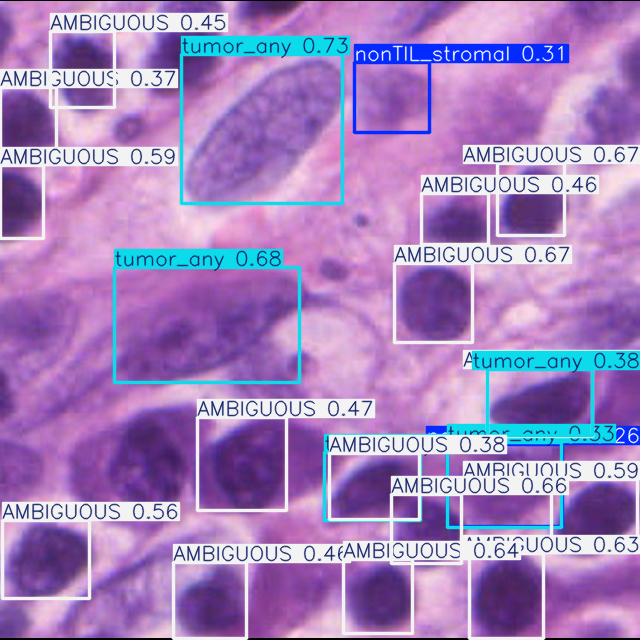

In [36]:
# Load and use the trained model for inference

# Load the trained model
model = YOLO('/content/drive/MyDrive/YOLOV8/best.pt')

# Perform inference on an image
result = model(dataset['test'][2]['file_name'] + ".png")
# Process results list
for result in result:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    result.show()  # display to screen
    result.save(filename='result.jpg')  # save to disk

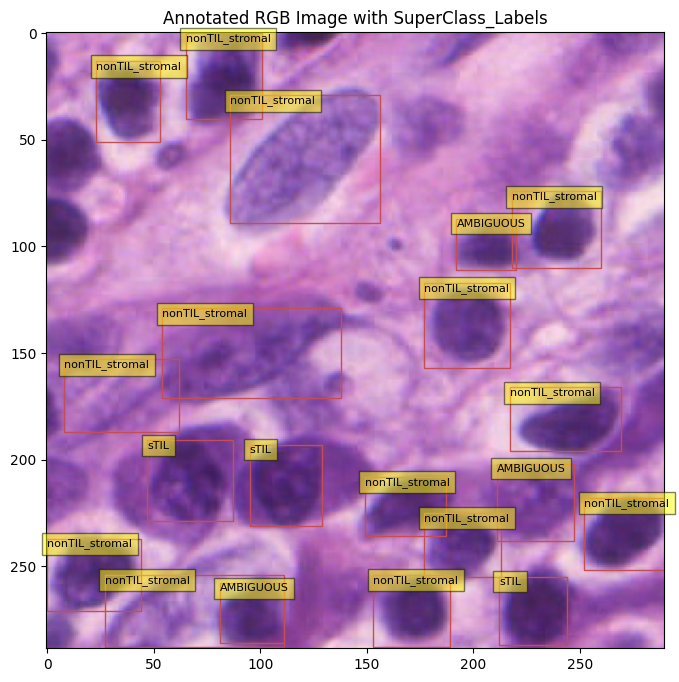

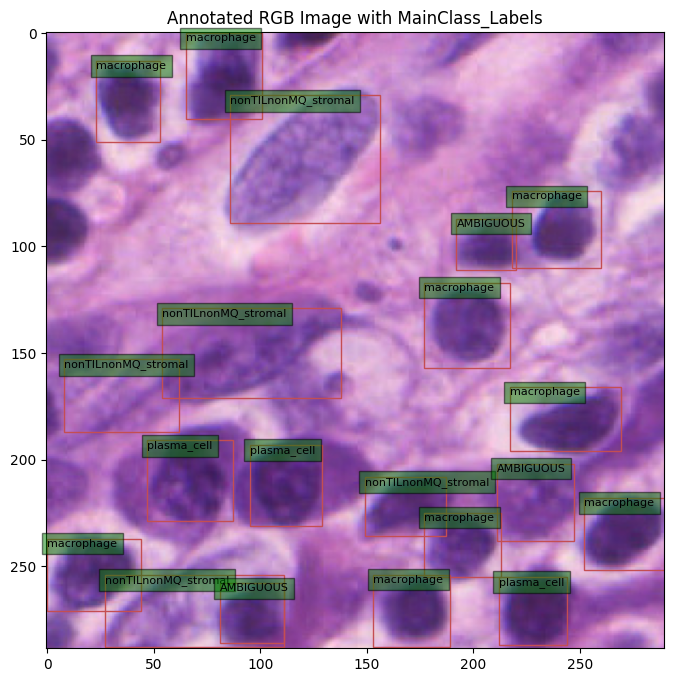

In [37]:
# Ground truth
entry = dataset['test'][2]
plot_annotated_image_with_labels(entry)

### Example 2


image 1/1 /content/drive/MyDrive/YOLOV8_MAIN/images/test/TCGA-BH-A0AV-DX1_id-5ea4099dddda5f8398981d96_left-78704_top-57926_bottom-58192_right-78973.png: 640x640 2 nonTIL_stromals, 11 tumor_anys, 5 other_nucleuss, 37.1ms
Speed: 1.8ms preprocess, 37.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


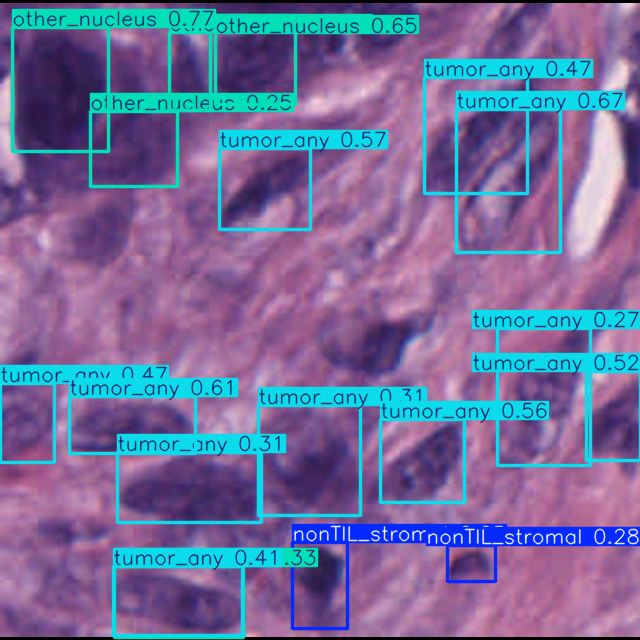

In [38]:
# Load and use the trained model for inference

# Load the trained model
model = YOLO('/content/drive/MyDrive/YOLOV8/best.pt')

# Perform inference on an image
result = model(dataset['test'][4]['file_name'] + ".png")
# Process results list
for result in result:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    result.show()  # display to screen
    result.save(filename='result.jpg')  # save to disk

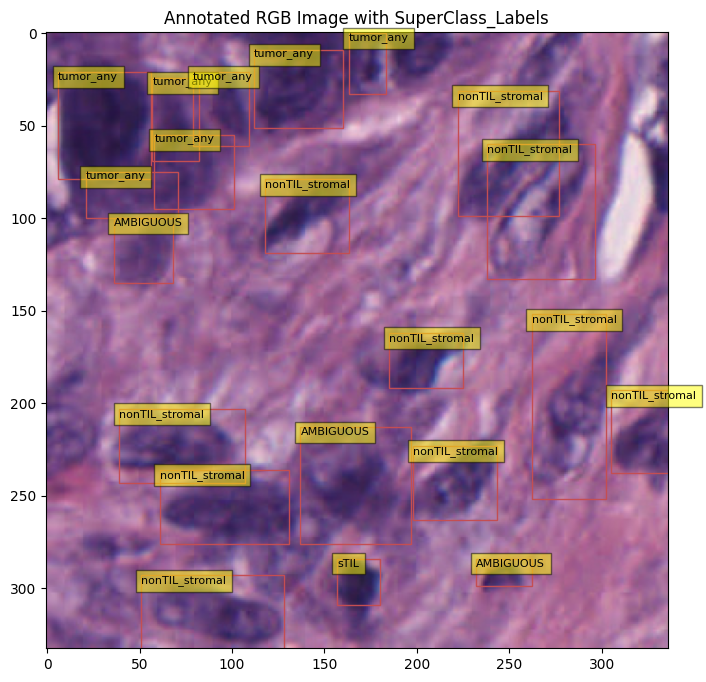

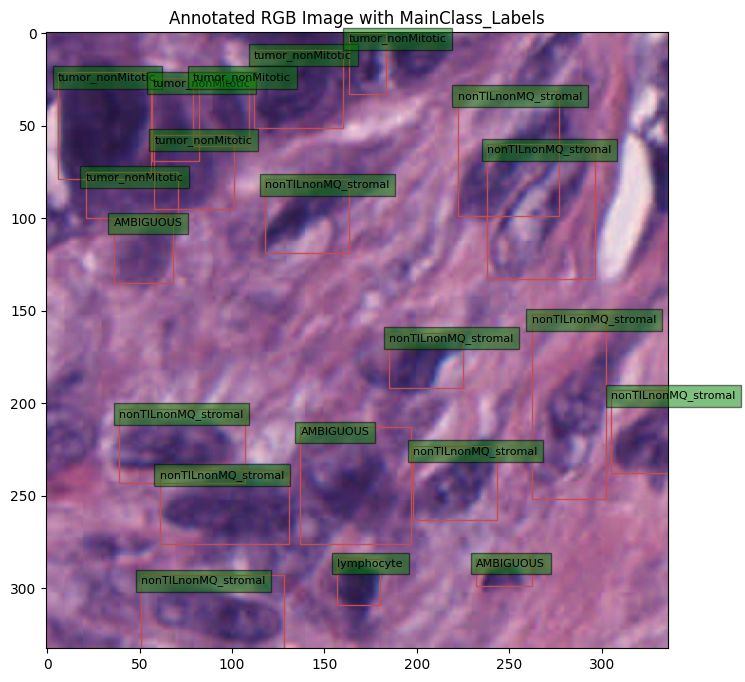

In [29]:
# Ground truth
entry = dataset['test'][4]
plot_annotated_image_with_labels(entry)